# **Bridge Grades Calculation: Final Bridge Grade Calculation Engine**

```{admonition} Overview
:class: tip

This notebook serves as the **central scoring engine** for the Bridge Grades methodology, combining all processed data sources to calculate final Bridge Grades for members of the 119th U.S. Congress. It implements the complete scoring algorithm that transforms raw collaboration metrics into letter grades (A, B, C, F) that identify "bridgers" from "dividers."

The notebook processes data from different sources (A, B, C, D, E, F, M, N, P) and applies configurable weights to generate normalized scores that are then converted to final Bridge Grades.
```

## **Data Sources**

### **Input Files**
All processed data sources from previous notebooks:

- **`119th_Congress_20250809.csv`** - Master congressional roster with bioguide IDs, states, districts, parties, and chambers
- **`bridge_grade_source_a_cross_party_supported_bills.csv`** - Source A: Authors of bills with cross-party sponsors
- **`bridge_grade_source_b_cross_party_cosponsors.csv`** - Source B: Cosponsors of cross-party bills
- **`bridge_grades_source_cdef_app_communication.csv`** - Source C/D/E/F: APP communications data (bipartisanship and personal attacks)
- **`bridge_grade_source_m_house_pvi.csv`** - Source M: Cook Political PVI for House districts (House)
- **`bridge_grade_source_m_senate_pvi.csv`** - Source M: Cook Political PVI for House districts (Senate)
- **`bridge_grade_source_n_house_ideology.csv`** - Source N: VoteView ideological scores (House)
- **`bridge_grade_source_n_senate_ideology.csv`** - Source N: VoteView ideological scores (Senate)
- **`problem_solvers.csv`** - Source P: Problem Solvers Caucus
- **`profiles.csv`** - Attendance data for filtering

### **Output Files**
- **`house_scores_119.xlsx`** - Complete House member scores and grades
- **`senate_scores_119.xlsx`** - Complete Senate member scores and grades

---

## **Main Functions**

### **1. Configuration and Setup**
**Purpose:** Sets up scoring parameters and loads all data sources

**Key Parameters:**
- `att_pct = 0.2` - Minimum attendance threshold (20%) for grading eligibility
- `weights` - Configurable weights for each data source (A=3, B=3, C=1, D=1, etc.)
- `bonus_scaling_factor`: scaling factors that control the effect of bonuses on the score. (All these factors were sought by methodologies assigned individually to each one)

**Code Example:**
```python
att_pct   = 0.2    # minimum attendance proportion

weights   = {
    'A': 3,     # Source A: num_bills_with_cross_party_cosponsors
    'B': 2,     # Source B: num_cross_party_cosponsored_bills
    'C': 1,   # Source C: communications that support members of the opposite party
    'D': 1,   # Source D: proportion of communications that support members of the opposite party
    'E': 1,   # Source E: communications classified as personal attacks
    'F': 1,   # Source F: proportion of communications classified as personal attacks
}

bonuses = {
    'pvi_value_cap': 15, # number of PVI points to cap at
    'max_P_bonus_scaling_factor': 0.01, # scaling factor for P bonus
    'max_N_bonus_scaling_factor': 0.05, # scaling factor for N bonus
    'max_M_bonus_scaling_factor': 0.38 # scaling factor for M bonus
}
```

### **2. Attendance Filtering**
**Purpose:** Removes members with attendance below threshold from grading

**Process:**
- Calculates attendance percentage for each member
- Filters out members below 20% attendance threshold
- Applies filtering to both House and Senate datasets

### **3. Data Source Integration**
**Purpose:** Merges all processed data sources into master datasets

**For Each Source (A through F):**
- Loads processed CSV file
- Merges with master dataset using bioguide_id
- Fills missing values appropriately (0 for counts, mean for percentages)
- Calculates normalized scores using normal distribution CDF
- Renames columns with source prefix for clarity

### **4. Final Score Calculation**
**Purpose:** Combines all normalized scores using weighted algorithm

**Algorithm:**
```python
def cal_score(data, weights, bonuses):
    # Copy the data to avoid modifying the original dataframe
    temp_data = data.copy()

    # Initialize columns
    temp_data['score_T'] = 0

    # Calculate 'score_T' by adding weighted norm values for each category
    for i in weights.keys():
        temp_data['score_T'] += temp_data[f"norm_{i}"] * weights[i]


    # Calculate scores for ideology multipliers BEFORE the caucus score
    # Add bonuses
    temp_data['bonus_m'] = (temp_data['score_T']*(1+(temp_data['Cook PVI Raw']/100)*bonuses['max_M_bonus_scaling_factor']))-temp_data['score_T']


    temp_data['bonus_n'] = temp_data['score_T'] * bonuses['max_N_bonus_scaling_factor'] * temp_data['ideology_dist']

    #the bonuses M and N to 0 if they are negative

    temp_data['bonus_m'] = temp_data['bonus_m'].clip(lower=0)
    temp_data['bonus_n'] = temp_data['bonus_n'].clip(lower=0)


    temp_data['bonus_p'] = np.ceil(
      bonuses['max_P_bonus_scaling_factor']
      * temp_data['score_T'].max()
      * temp_data['P_flag']
    ).astype(int)

    print( temp_data['bonus_p'] )
    print(temp_data['score_T'].max())

    temp_data['score_U'] = temp_data['score_T'] + temp_data['bonus_m'] + temp_data['bonus_n'] + temp_data['bonus_p']

    # Calculate mean, std, and median of 'score_S'
    mean_U = round(temp_data['score_U'].mean(), 2)
    std_U = round(temp_data['score_U'].std(), 2)
    median_U = round(temp_data['score_U'].median(), 2)

    # Normalize 'score_U' using the cumulative distribution function (CDF)
    temp_data['norm_U'] = norm.cdf(temp_data['score_U'], mean_U, std_U) * 100

    # Define the grade assignment function based on the calculated scores
    def assign_grade(grade):
        if grade > mean_U + std_U:
            return 'A'
        elif grade > median_U:
            return 'B'
        elif grade > mean_U - std_U:
            return 'C'
        else:
            return 'F'

    # Apply the grade assignment to the 'score_S' column
    temp_data['Grade'] = temp_data['score_U'].apply(assign_grade)

    return temp_data
```

---

## **Outputs**

### **Final Datasets**
1. **House Scores Dataset** (`house_scores_119.xlsx`)
   - All House members with complete scoring breakdown
   - Individual source scores and normalized values
   - Final composite score and letter grade

2. **Senate Scores Dataset** (`senate_scores_119.xlsx`)
   - All Senate members with complete scoring breakdown
   - Individual source scores and normalized values
   - Final composite score and letter grade

### **Key Columns in Output**
- **Identification:** Name, Chamber, bioguide_id, State, District, Party
- **Raw Source Data:** A through F source values
- **Normalized Scores:** norm_A through norm_F (0-100 scale)
- **Composite Scores:** score_T (base), score_P (caucus), score_M (PVI), score_N (ideology), score_U (final)
- **Final Results:** norm_U (normalized final), Grade (A/B/C/F)

---

## **Technical Requirements**

### **Dependencies**
- **pandas** - Data manipulation and analysis
- **numpy** - Numerical operations
- **scipy.stats** - Statistical functions (normal distribution CDF)
- **seaborn** - Data visualization
- **matplotlib.pyplot** - Plotting

### **Data Processing Notes**
- **Missing Value Handling:** Fills missing values with 0 for counts, column mean for percentages
- **Duplicate Removal:** Removes duplicate bioguide_id entries
- **Data Type Conversion:** Converts numeric columns to appropriate types for export
- **Chamber Separation:** Processes House and Senate separately due to different data structures

---

## **Data Quality**

### **Validation Checks**
- **Attendance Filtering:** Removes members below 20% attendance threshold
- **Duplicate Handling:** Removes duplicate bioguide_id entries
- **Missing Data:** Appropriate filling strategies for each data type
- **Score Validation:** Ensures all scores are within expected ranges
---

# **Notebook Walkthrough: Bridge Grades Calculation**

## **Configuration & File Existence Checks**

In this section we verify that all input files exist before proceeding, and validate that our `weights` dictionary matches the set of loaded source labels.

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm

```python
# Global parameters
att_pct   = 0.2    # minimum attendance proportion
weights   = {
    'A': 3,     # Source A: num_bills_with_cross_party_cosponsors
    'B': 2,     # Source B: num_cross_party_cosponsored_bills
    'C': 1,   # Source C: communications that support members of the opposite party
    'D': 1,   # Source D: proportion of communications that support members of the opposite party
    'E': 1,   # Source E: communications classified as personal attacks
    'F': 1,   # Source F: proportion of communications classified as personal attacks
}

bonuses = {
    'pvi_value_cap': 15, # number of PVI points to cap at
    'max_P_bonus_scaling_factor': 0.01, # scaling factor for P bonus
    'max_N_bonus_scaling_factor': 0.05, # scaling factor for N bonus
    'max_M_bonus_scaling_factor': 0.38 # scaling factor for M bonus
}

# Define all required file paths
BASE_DIR = '/content/drive/MyDrive/Bridge Grades Snapshot August/Data'
# BASE_DIR = '../Data'
paths = {
    'meta':        f"{BASE_DIR}/Source C-D-E-F/Input files/119th_Congress_20250809.csv",
    'A':           f"{BASE_DIR}/Source A-B/Output files/bridge_grade_source_a_cross_party_supported_bills.csv",
    'B':           f"{BASE_DIR}/Source A-B/Output files/bridge_grade_source_b_cross_party_cosponsors.csv",
    'CDEF':        f"{BASE_DIR}/Source C-D-E-F/Output files/bridge_grades_source_cdef_app_communication.csv",
    'M_House':     f"{BASE_DIR}/Source M/Output files/bridge_grade_source_m_house_pvi.csv",
    'M_Senate':    f"{BASE_DIR}/Source M/Output files/bridge_grade_source_m_senate_pvi.csv",
    'N_House':     f"{BASE_DIR}/Source N/Output files/bridge_grade_source_n_house_ideology.csv",
    'N_Senate':    f"{BASE_DIR}/Source N/Output files/bridge_grade_source_n_senate_ideology.csv",
    'P':           f"{BASE_DIR}/Source P/problem_solvers.csv",
}

# Load raw APP profiles (attendance data)
source_APP_profiles = pd.read_csv(
    f"{BASE_DIR}/profiles.csv",
    usecols=['full_name','bioguide_id','attendance_total','attendance_max']
)

# Check each file exists
missing_files = [key for key, p in paths.items() if not os.path.exists(p)]
if missing_files:
    raise FileNotFoundError(f"Missing input files for sources: {missing_files}")
print("All input files found.")
```


## **Load DataFrames & Validate Weights**
We load each CSV into a DataFrame and then ensure the set of weight keys matches the loaded source labels exactly.

In [ ]:
# Load master metadata
meta_data        = pd.read_csv(paths['meta'])

# Load each source DataFrame
source_A         = pd.read_csv(paths['A'])
source_B         = pd.read_csv(paths['B'])
source_APP       = pd.read_csv(paths['CDEF'])
source_M_House   = pd.read_csv(paths['M_House'])
source_M_Senate  = pd.read_csv(paths['M_Senate'])
source_N_House   = pd.read_csv(paths['N_House'])
source_N_Senate  = pd.read_csv(paths['N_Senate'])
source_P         = pd.read_csv(paths['P'])

# 2.3 Verify weight keys vs. sources to be scored (A–O)
loaded_sources = set(weights.keys())
expected_sources = {'A','B','C','D','E','F'}
if loaded_sources != expected_sources:
    raise ValueError(
        f"Weights keys {loaded_sources} do not match expected {expected_sources}"
    )

print("Weights validated against source labels.")

Weights validated against source labels.


## **Build Base Member Tables**

In this section we initialize our working DataFrames for the House and Senate by subsetting the master `meta_data`. These tables will be the foundation for merging each source’s metrics.

In [ ]:
# Preview master metadata
meta_data.head(10)

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,2025,NaN,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,2023,NaN,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...
2,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,2025,NaN,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...
3,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,2021,NaN,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...
4,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,2019,NaN,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...
5,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,2023,NaN,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...
6,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,2025,NaN,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...
7,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,2024,NaN,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...
8,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,2019,NaN,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...
9,M001244,Ashley Moody,Ashley,NaN,Moody,NaN,Senate,Florida,NaN,Republican,2025,NaN,2025-05-07T10:42:23Z,No Image Available


In [ ]:
# Subset to House members
house_final = meta_data.query("Chamber=='House'").copy()
print(house_final.shape[0])
house_final.head()


431


,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,2025,NaN,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,2023,NaN,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...
7,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,2024,NaN,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...
8,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,2019,NaN,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...
10,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,2023,NaN,2025-04-30T18:14:58Z,https://www.congress.gov/img/member/681231f624...


In [ ]:
# Subset to Senate members
senate_final = meta_data.query("Chamber=='Senate'").copy()
print(senate_final.shape[0])
senate_final.head()

100


,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url
2,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,2025,NaN,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...
3,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,2021,NaN,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...
4,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,2019,NaN,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...
5,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,2023,NaN,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...
6,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,2025,NaN,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...


## **Attendance Filtering**
Legislators below the minimum attendance threshold (`att_pct`) are excluded from scoring. We calculate each member’s attendance percentage and remove those below `att_pct`.

In [ ]:
# Extract attendance data
source_att = source_APP_profiles[[
    'full_name','bioguide_id','attendance_total','attendance_max'
]].copy()
source_att.head()

,full_name,bioguide_id,attendance_total,attendance_max
0,Maria Cantwell,C000127,414.0,414
1,Amy Klobuchar,K000367,410.0,414
2,Bernard Sanders,S000033,371.0,414
3,Sheldon Whitehouse,W000802,393.0,414
4,John Barrasso,B001261,411.0,414


In [ ]:
source_att[source_att['attendance_total'].isna()]

,full_name,bioguide_id,attendance_total,attendance_max
210,Aumua Amata Radewagen,R000600,NaN,168
500,Kimberlyn King-Hinds,K000404,NaN,168
520,Pablo José Hernández Rivera,H001103,NaN,168


In [ ]:
# Note, missing legislators are non-voting members from territories.

In [ ]:
# Fill missing totals with zero
source_att['attendance_total'] = source_att['attendance_total'].fillna(0)

In [ ]:
# Compute attendance percentage
source_att['attendance_pct'] = (
    source_att['attendance_total'] / source_att['attendance_max']
)

In [ ]:
# Identify members below threshold
low_att = source_att.query("attendance_pct < @att_pct").drop_duplicates(subset='bioguide_id')
low_att

,full_name,bioguide_id,attendance_total,attendance_max,attendance_pct
95,Eleanor Norton,N000147,4.0,168,0.023810
207,Stacey Plaskett,P000610,7.0,168,0.041667
210,Aumua Amata Radewagen,R000600,0.0,168,0.000000
405,James (Jim) Moylan,M001219,6.0,168,0.035714
500,Kimberlyn King-Hinds,K000404,0.0,168,0.000000
520,Pablo José Hernández Rivera,H001103,0.0,168,0.000000


In [ ]:
## Note: all of the legislators with low attendance are non-voting members from territories, so this makes sense!

In [ ]:
# Remove low‐attendance members from both tables
to_remove = set(low_att['bioguide_id'])
house_final = house_final[~house_final['bioguide_id'].isin(to_remove)].copy()
senate_final = senate_final[~senate_final['bioguide_id'].isin(to_remove)].copy()

In [ ]:
print(house_final.shape[0]) # total number of members in the house
print(senate_final.shape[0]) # total number of members in the senate

431
100


### **Source A: Authors of Bills with Cross-Party Sponsors**

Rewards Members of the 119th U.S. Congress for sponsoring legislation that attracted at least one cosponsor from the opposite party. We take each legislator’s total count of such bills, fill true “no-activity” values with zeros, and convert counts into a 0–100 percentile score.

- **Data origin:** OpenStates bill sponsorship CSV for the 119th Congress  
- **Download link:** https://open.pluralpolicy.com/data/session-csv/  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** “Source A – B: Legislator and Sponsorship Data”  

> **Why fill with zeros?**  
> A missing count indicates the legislator had **no** cross-party bills. Zero appropriately reflects “no activity,” not unknown data.

---



#### **Load & Prepare Source A**

In [ ]:
# Select only the primary bioguide ID and cross-party bill count
source_A = source_A[['primary_bioguide_id', 'num_bills_with_cross_party_cosponsors']].copy()
assert {'primary_bioguide_id','num_bills_with_cross_party_cosponsors'} <= set(source_A.columns), \
    "Unexpected columns in source_A"
source_A.head()

,primary_bioguide_id,num_bills_with_cross_party_cosponsors
0,K000367,51
1,C001075,49
2,C001056,48
3,G000386,43
4,F000466,42


#### **Merge & Normalize for House**

In [ ]:
# Merge into house_final by bioguide_id
house_final = house_final.merge(
    source_A.rename(columns={'primary_bioguide_id':'bioguide_id'}),
    on='bioguide_id',
    how='left'
)

In [ ]:
# Check raw data to see if true
house_final[house_final[
    'num_bills_with_cross_party_cosponsors'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,num_bills_with_cross_party_cosponsors
10,J000299,Mike Johnson,Mike,NaN,Johnson,NaN,House,Louisiana,4.0,Republican,2017,NaN,2025-04-28T13:05:21Z,https://www.congress.gov/img/member/67ffcb2af2...,NaN
257,F000110,Cleo Fields,Cleo,NaN,Fields,NaN,House,Louisiana,6.0,Democratic,2025,NaN,2025-04-28T13:04:20Z,https://www.congress.gov/img/member/677426250b...,NaN
258,H000874,Steny H. Hoyer,Steny,H.,Hoyer,NaN,House,Maryland,5.0,Democratic,1981,NaN,2025-04-28T13:04:20Z,https://www.congress.gov/img/member/116_rp_md_...,NaN
301,G000586,"Jesús G. ""Chuy"" García",Jesús,G.,García,Chuy,House,Illinois,4.0,Democratic,2019,NaN,2025-04-28T13:04:18Z,https://www.congress.gov/img/member/g000586_20...,NaN
424,P000197,Nancy Pelosi,Nancy,NaN,Pelosi,NaN,House,California,11.0,Democratic,1987,NaN,2025-04-28T13:04:14Z,https://www.congress.gov/img/member/p000197_20...,NaN


```{note}
- Mike Johson (speaker, republican)
- Hakeem Jeffries (democratic minority leader)
- Nancy Pelosi (speaker emerita)
likely are not doing a lot of bill sponsorship in general, so this makes sense

- Steney Hoyer, might be close to retirement, so this makes sense
- Chuy Garcia and Greg Casar very progressive, but still double check
- Cleo Fields worth double checking
```

In [ ]:
# Fill missing counts (no cross-party bills) with zero
house_final['num_bills_with_cross_party_cosponsors'] = house_final[
    'num_bills_with_cross_party_cosponsors'
].fillna(0)

In [ ]:
# Normalize A House
house_final['A: num_bills_with_cross_party_cosponsors'] = \
    house_final['num_bills_with_cross_party_cosponsors']


# Recalculate mean and std
mean_A = house_final['num_bills_with_cross_party_cosponsors'].mean()
std_A = house_final['num_bills_with_cross_party_cosponsors'].std()

# Add normalized column
house_final['norm_A'] = norm.cdf(house_final['num_bills_with_cross_party_cosponsors'], mean_A, std_A) * 100

# Clean up
house_final.drop(columns=['num_bills_with_cross_party_cosponsors'], inplace=True)
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,2025,NaN,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...,1.0,20.874310
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,2023,NaN,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...,1.0,20.874310
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,2024,NaN,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...,1.0,20.874310
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,2019,NaN,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...,15.0,96.832815
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,2023,NaN,2025-04-30T18:14:58Z,https://www.congress.gov/img/member/681231f624...,2.0,26.754660


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into senate_final by bioguide_id
senate_final = senate_final.merge(
    source_A.rename(columns={'primary_bioguide_id':'bioguide_id'}),
    on='bioguide_id',
    how='left'
)

In [ ]:
# Check raw data to see if true
senate_final[senate_final[
    'num_bills_with_cross_party_cosponsors'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,num_bills_with_cross_party_cosponsors


In [ ]:
## Note: No missing values in Senate

In [ ]:
# Fill missing counts with zero
senate_final['num_bills_with_cross_party_cosponsors'] = senate_final[
    'num_bills_with_cross_party_cosponsors'
].fillna(0)

In [ ]:
# Normalize A - Senate
senate_final['A: num_bills_with_cross_party_cosponsors'] = \
    senate_final['num_bills_with_cross_party_cosponsors']

# Recalculate mean and std
mean_A = senate_final['num_bills_with_cross_party_cosponsors'].mean()
std_A = senate_final['num_bills_with_cross_party_cosponsors'].std()

# Add normalized column
senate_final['norm_A'] = norm.cdf(senate_final['num_bills_with_cross_party_cosponsors'], mean_A, std_A) * 100

# Drop duplicates and cleanup
senate_final.drop_duplicates(subset='bioguide_id', inplace=True)
senate_final.drop(columns=['num_bills_with_cross_party_cosponsors'], inplace=True)
senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,2025,NaN,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...,6,24.239891
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,2021,NaN,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...,8,30.450752
3,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,2019,NaN,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...,13,48.258655
4,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,2023,NaN,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...,15,55.703808
5,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,2025,NaN,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...,3,16.371664


### **Source B: Ranked People Who Cosponsor Bills**

This section processes **Source B**, which rewards Members of the 119th U.S. Congress for **cosponsoring** bills authored by another party. We take each legislator’s total count of such cross-party cosponsorships, fill true zero-activity values with zeros, and convert counts into a  0–100 percentile score.

- **Data origin:** OpenStates bill sponsorship CSV for the 119th Congress  
- **Download link:** https://open.pluralpolicy.com/data/session-csv/  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** “Source A – B: Legislator and Sponsorship Data”  
- **Note:** Missing values (no cross-party cosponsorships) are filled with 0  

> **Why fill with zeros?**  
> A missing count indicates the legislator did **not** cosponsor any cross-party bills. Zero correctly represents “no activity.”

---


#### **Load & Prepare Source B**

In [ ]:
# Select only bioguide_id and cosponsor count, then copy
assert {'bioguide_id','num_cross_party_cosponsored_bills'} <= set(source_B.columns), \
    "Unexpected columns in source_B"
source_B = source_B[['bioguide_id','num_cross_party_cosponsored_bills']].copy()
source_B.head(3)

,bioguide_id,num_cross_party_cosponsored_bills
0,F000466,433
1,D000230,240
2,P000613,167


#### **Merge & Normalize for House**

In [ ]:
# Merge into house_final by bioguide_id
house_final = house_final.merge(
    source_B,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final[house_final[
    'num_cross_party_cosponsored_bills'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,num_cross_party_cosponsored_bills


In [ ]:
## Note: No missing values for the house

In [ ]:
# Fill missing counts with zero
house_final['num_cross_party_cosponsored_bills'] = \
    house_final['num_cross_party_cosponsored_bills'].fillna(0)

In [ ]:
# Normalize B - House

# # Compute CDF percentile
house_final['B: num_cross_party_cosponsored_bills'] = \
    house_final['num_cross_party_cosponsored_bills']

# Recalculate mean and std
mean_B = house_final['num_cross_party_cosponsored_bills'].mean()
std_B = house_final['num_cross_party_cosponsored_bills'].std()

# Add normalized column
house_final['norm_B'] = norm.cdf(house_final['num_cross_party_cosponsored_bills'], mean_B, std_B) * 100

# Clean up raw column
house_final.drop(columns=['num_cross_party_cosponsored_bills'], inplace=True)
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,2025,NaN,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...,1.0,20.874310,6,27.624352
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,2023,NaN,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...,1.0,20.874310,19,41.338114
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,2024,NaN,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...,1.0,20.874310,17,39.105279
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,2019,NaN,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...,15.0,96.832815,73,90.981076
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,2023,NaN,2025-04-30T18:14:58Z,https://www.congress.gov/img/member/681231f624...,2.0,26.754660,14,35.824398


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into senate_final by bioguide_id
senate_final = senate_final.merge(
    source_B,
    on='bioguide_id',
    how='left'
)

In [ ]:
senate_final[senate_final[
    'num_cross_party_cosponsored_bills'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,num_cross_party_cosponsored_bills


In [ ]:
## Note: No missing values for the Senate

In [ ]:
# Fill missing counts with zero
senate_final['num_cross_party_cosponsored_bills'] = \
    senate_final['num_cross_party_cosponsored_bills'].fillna(0)

In [ ]:
# Normalize B - Senate
senate_final['B: num_cross_party_cosponsored_bills'] = \
    senate_final['num_cross_party_cosponsored_bills']


# Recalculate mean and std
mean_B = senate_final['num_cross_party_cosponsored_bills'].mean()
std_B = senate_final['num_cross_party_cosponsored_bills'].std()

# Add normalized column
senate_final['norm_B'] = norm.cdf(senate_final['num_cross_party_cosponsored_bills'], mean_B, std_B) * 100

# Drop duplicate legislators and cleanup
senate_final.drop_duplicates(subset='bioguide_id', inplace=True)
senate_final.drop(columns=['num_cross_party_cosponsored_bills'], inplace=True)
senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,2025,NaN,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...,6,24.239891,24,29.006544
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,2021,NaN,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...,8,30.450752,57,75.553948
3,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,2019,NaN,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...,13,48.258655,21,25.257922
4,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,2023,NaN,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...,15,55.703808,63,82.080297
5,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,2025,NaN,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...,3,16.371664,13,16.645559


### **Source C: Communication – Bipartisanship (Sum)**

Rewards Members of the 119th U.S. Congress for communications that support members of the opposite party. We count each legislator’s total **outcome_bipartisanship** flags, fill true zero‐activity with zeros, and convert counts into a 0–100 percentile score.

- **Data origin:** American Political Pulse communications CSV (2025 download)  
- **Download link:** https://americaspoliticalpulse.com/data/ (Download “US officials – 2025”)  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** *Source C–D–E–F: App_Communications_Calculations*  

> **Why fill with zeros?**  
> A missing `outcome_bipartisanship` value means the legislator made **no** bipartisan supportive communications. Zero accurately indicates “none.”  
---

#### **Load & Prepare Source C**

In [ ]:
# Ensure expected column exists
assert 'outcome_bipartisanship' in source_APP.columns, "Missing 'outcome_bipartisanship' in source_APP"

# Subset and copy
source_C = source_APP[['bioguide_id','outcome_bipartisanship']].copy()
source_C.head()

,bioguide_id,outcome_bipartisanship
0,A000055,10.0
1,A000148,99.0
2,A000369,20.0
3,A000370,12.0
4,A000371,3.0


In [ ]:
# Merge into house_final
house_final = house_final.merge(
    source_C,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final[house_final[
    'outcome_bipartisanship'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,outcome_bipartisanship


In [ ]:
## Note: No missing values for house

In [ ]:
# Fill missing with zero
house_final['outcome_bipartisanship'] = \
    house_final['outcome_bipartisanship'].fillna(0)

In [ ]:
# Normalize C - House
house_final['C: outcome_bipartisanship'] = \
    house_final['outcome_bipartisanship']

# Recalculate mean and std
mean_C = house_final['outcome_bipartisanship'].mean()
std_C = house_final['outcome_bipartisanship'].std()

# Add normalized column
house_final['norm_C'] = norm.cdf(house_final['outcome_bipartisanship'], mean_C, std_C) * 100

# Drop raw column and remove any duplicates
house_final.drop(columns=['outcome_bipartisanship'], inplace=True)
if house_final['bioguide_id'].duplicated().any():
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,2025,NaN,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...,1.0,20.874310,6,27.624352,2.0,15.141404
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,2023,NaN,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...,1.0,20.874310,19,41.338114,28.0,39.575556
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,2024,NaN,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...,1.0,20.874310,17,39.105279,8.0,19.666071
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,2019,NaN,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...,15.0,96.832815,73,90.981076,60.0,75.126253
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,2023,NaN,2025-04-30T18:14:58Z,https://www.congress.gov/img/member/681231f624...,2.0,26.754660,14,35.824398,36.0,48.857402


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into senate_final
senate_final = senate_final.merge(
    source_C,
    on='bioguide_id',
    how='left'
)

In [ ]:
senate_final[senate_final[
    'outcome_bipartisanship'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,outcome_bipartisanship


In [ ]:
## Note: No missing values for Senate

In [ ]:
# Fill missing with zero
senate_final['outcome_bipartisanship'] = \
    senate_final['outcome_bipartisanship'].fillna(0)

In [ ]:
# Normalize C - Senate
senate_final['C: outcome_bipartisanship'] = \
    senate_final['outcome_bipartisanship']

# Recalculate mean and std
mean_C = senate_final['outcome_bipartisanship'].mean()
std_C = senate_final['outcome_bipartisanship'].std()

# Add normalized column
senate_final['norm_C'] = norm.cdf(senate_final['outcome_bipartisanship'], mean_C, std_C) * 100

# Clean up
if senate_final['bioguide_id'].duplicated().any():
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)
senate_final.drop(columns=['outcome_bipartisanship'], inplace=True)

senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,start_year,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,2025,NaN,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...,6,24.239891,24,29.006544,2.0,11.809128
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,2021,NaN,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...,8,30.450752,57,75.553948,76.0,38.604383
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,2019,NaN,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...,13,48.258655,21,25.257922,9.0,13.568212
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,2023,NaN,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...,15,55.703808,63,82.080297,198.0,88.214775
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,2025,NaN,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...,3,16.371664,13,16.645559,39.0,23.052655


### **Source D: Communication – Bipartisanship (Mean)**

Rewards Members of the 119th U.S. Congress for the **proportion** of their communications that are supportive of the opposite party. We take each legislator’s percentage (`outcome_bipartisanship_pct`), fill true zero‐activity values with zeros, and convert percentages into a percentile score using median & MAD.

- **Data origin:** American Political Pulse communications CSV (2025 download)  
- **Download link:** https://americaspoliticalpulse.com/data/ (Download “US officials – 2025”)  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** *Source C–D–E–F: App_Communications_Calculations*  

> **Why fill with zeros?**  
> A missing percentage means the legislator made no bipartisan communications—zero accurately reflects “none.”
---

#### **Load & Prepare Source D**

In [ ]:
# Validate expected column
assert 'outcome_bipartisanship_pct' in source_APP.columns, \
    "Missing 'outcome_bipartisanship_pct' in source_APP"

# Subset and copy
source_D = source_APP[['bioguide_id','outcome_bipartisanship_pct']].copy()
source_D.head()

,bioguide_id,outcome_bipartisanship_pct
0,A000055,3.906250
1,A000148,10.963455
2,A000369,6.944444
3,A000370,4.210526
4,A000371,2.439024


In [ ]:
# Merge into house_final
house_final = house_final.merge(
    source_D,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final[house_final[
    'outcome_bipartisanship_pct'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,outcome_bipartisanship_pct


In [ ]:
### Note: No missing values for House

In [ ]:
# Fill missing percentages with zero
house_final['outcome_bipartisanship_pct'] = \
    house_final['outcome_bipartisanship_pct'].fillna(0)

In [ ]:
# Normalize D - House
house_final['D: outcome_bipartisanship_pct'] = \
    house_final['outcome_bipartisanship_pct']

# Recalculate mean and std
mean_D = house_final['outcome_bipartisanship_pct'].mean()
std_D = house_final['outcome_bipartisanship_pct'].std()

# Add normalized column
house_final['norm_D'] = norm.cdf(house_final['outcome_bipartisanship_pct'], mean_D, std_D) * 100

# Cleanup
house_final.drop(columns=['outcome_bipartisanship_pct'], inplace=True)
if house_final['bioguide_id'].duplicated().any():
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,2025-07-14T14:25:50Z,https://www.congress.gov/img/member/677448630b...,1.0,20.874310,6,27.624352,2.0,15.141404,4.878049,43.384639
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,2025-06-13T13:48:04Z,https://www.congress.gov/img/member/684c235633...,1.0,20.874310,19,41.338114,28.0,39.575556,1.842105,15.378290
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,2025-05-09T13:45:32Z,https://www.congress.gov/img/member/681dfed94f...,1.0,20.874310,17,39.105279,8.0,19.666071,5.095541,45.801824
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,2025-05-08T13:36:39Z,https://www.congress.gov/img/member/681bc0e6b7...,15.0,96.832815,73,90.981076,60.0,75.126253,7.633588,72.850883
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,2025-04-30T18:14:58Z,https://www.congress.gov/img/member/681231f624...,2.0,26.754660,14,35.824398,36.0,48.857402,4.411765,38.295997


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into house_final
senate_final = senate_final.merge(
    source_D,
    on='bioguide_id',
    how='left'
)

In [ ]:
senate_final[senate_final[
    'outcome_bipartisanship_pct'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,end_year,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,outcome_bipartisanship_pct


In [ ]:
## Note: No missing values for Senate

In [ ]:
# Fill missing percentages with zero
senate_final['outcome_bipartisanship_pct'] = \
    senate_final['outcome_bipartisanship_pct'].fillna(0)

In [ ]:
# Normalize D - Senate
senate_final['D: outcome_bipartisanship_pct'] = \
    senate_final['outcome_bipartisanship_pct']

# Recalculate mean and std
mean_D = senate_final['outcome_bipartisanship_pct'].mean()
std_D = senate_final['outcome_bipartisanship_pct'].std()

# Add normalized column
senate_final['norm_D'] = norm.cdf(senate_final['outcome_bipartisanship_pct'], mean_D, std_D) * 100

# Cleanup
senate_final.drop(columns=['outcome_bipartisanship_pct'], inplace=True)
if senate_final['bioguide_id'].duplicated().any():
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)

senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,update_date,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,...,2025-06-07T10:30:29Z,https://www.congress.gov/img/member/677d8231fd...,6,24.239891,24,29.006544,2.0,11.809128,4.000000,19.172695
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,...,2025-06-03T13:18:42Z,https://www.congress.gov/img/member/l000570_20...,8,30.450752,57,75.553948,76.0,38.604383,6.959707,47.529597
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,...,2025-05-28T10:30:24Z,https://www.congress.gov/img/member/h001089_20...,13,48.258655,21,25.257922,9.0,13.568212,2.719033,11.086503
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,...,2025-05-24T10:30:30Z,https://www.congress.gov/img/member/fd3cb364b8...,15,55.703808,63,82.080297,198.0,88.214775,6.954689,47.474948
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,...,2025-05-17T10:30:27Z,https://www.congress.gov/img/member/67c8694e61...,3,16.371664,13,16.645559,39.0,23.052655,6.280193,40.213106


### **Source E: Attack_Personal (Sum)**

Penalizes Members of the 119th U.S. Congress for communications classified as personal attacks. We count each legislator’s total **attack_personal** flags, fill true zero‐activity values with zeros, and convert into an **inverse** normalized score—higher attack counts yield lower scores.

- **Data origin:** American Political Pulse communications CSV (2025 download)  
- **Download link:** https://americaspoliticalpulse.com/data/ (Download “US officials – 2025”)  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** *Source C–D–E–F: App_Communications_Calculations*  

> **Why fill with zeros?**  
> A missing `attack_personal` means the legislator made **no** personal attacks. Zero accurately represents “none.”  

> **Normalized Score**  
> We apply `1 – CDF` so that more attacks → lower percentile score (0–100).

---

#### **Load & Prepare Source E**

In [ ]:
# Validate and subset
assert 'attack_personal' in source_APP.columns, "Missing 'attack_personal' in source_APP"
source_E = source_APP[['bioguide_id','attack_personal']].copy()
source_E.head()

,bioguide_id,attack_personal
0,A000055,3.0
1,A000148,76.0
2,A000369,1.0
3,A000370,3.0
4,A000371,4.0


#### **Merge & Normalize for House**

In [ ]:
# Merge into house_final
house_final = house_final.merge(
    source_E,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final[house_final[
    'attack_personal'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,attack_personal


In [ ]:
## Note: No missing values for House

In [ ]:
# Fill missing with zero (no personal attacks)
house_final['attack_personal'] = house_final['attack_personal'].fillna(0)


In [ ]:
# Normalize E - House
house_final['E: attack_personal'] = house_final['attack_personal']

# Recalculate mean and std
mean_E = house_final['attack_personal'].mean()
std_E = house_final['attack_personal'].std()

# Add normalized column
house_final['norm_E'] = 1- (norm.cdf(house_final['attack_personal'], mean_E, std_E) * 100)

# Cleanup
house_final.drop(columns=['attack_personal'], inplace=True)
if house_final['bioguide_id'].duplicated().any():
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,1.0,20.874310,6,27.624352,2.0,15.141404,4.878049,43.384639,0.0,-26.829767
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,1.0,20.874310,19,41.338114,28.0,39.575556,1.842105,15.378290,117.0,-97.480720
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,1.0,20.874310,17,39.105279,8.0,19.666071,5.095541,45.801824,3.0,-29.246708
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,15.0,96.832815,73,90.981076,60.0,75.126253,7.633588,72.850883,64.0,-81.068324
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,2.0,26.754660,14,35.824398,36.0,48.857402,4.411765,38.295997,12.0,-36.997215


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into senate_final
senate_final = senate_final.merge(
    source_E,
    on='bioguide_id',
    how='left'
)

In [ ]:
senate_final[senate_final[
    'attack_personal'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,image_url,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,attack_personal


In [ ]:
## Note: No missing values for Senate

In [ ]:
# Fill missing with zero
senate_final['attack_personal'] = senate_final['attack_personal'].fillna(0)

In [ ]:
# Normalize E - Senate
senate_final['E: attack_personal'] = senate_final['attack_personal']

mean_E = senate_final['attack_personal'].mean()
std_E = senate_final['attack_personal'].std()

# Add normalized column
senate_final['norm_E'] = 1 - (norm.cdf(senate_final['attack_personal'], mean_E, std_E) * 100)

# Cleanup
if senate_final['bioguide_id'].duplicated().any():
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)
senate_final.drop(columns=['attack_personal'], inplace=True)

senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,A: num_bills_with_cross_party_cosponsors,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,...,6,24.239891,24,29.006544,2.0,11.809128,4.000000,19.172695,0.0,-24.963767
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,...,8,30.450752,57,75.553948,76.0,38.604383,6.959707,47.529597,53.0,-40.802397
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,...,13,48.258655,21,25.257922,9.0,13.568212,2.719033,11.086503,10.0,-27.708748
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,...,15,55.703808,63,82.080297,198.0,88.214775,6.954689,47.474948,201.0,-83.489447
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,...,3,16.371664,13,16.645559,39.0,23.052655,6.280193,40.213106,5.0,-26.319176


### **Source F: Attack_Personal (Pct)**

Penalizes Members of the 119th U.S. Congress based on the **percentage** of their communications that are personal attacks. Higher attack rates → lower scores. We fill true zero‐activity with zeros, then apply a normalization.

- **Data origin:** American Political Pulse communications CSV (2025 download)  
- **Download link:** https://americaspoliticalpulse.com/data/ (Download “US officials – 2025”)  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** *Source C–D–E–F: App_Communications_Calculations*  

> **Why fill with zeros?**  
> A missing `attack_personal_pct` means the legislator made **no** personal-attack communications. Zero correctly represents “none.”  

> **Normalization**  
> Using `1 – CDF` ensures higher attack rates produce lower percentile scores.


#### **Load & Validate Source F**

In [ ]:
# Ensure expected column present
assert 'attack_personal_pct' in source_APP.columns, \
    "Missing 'attack_personal_pct' in source_APP"

# Subset and copy
source_F = source_APP[['bioguide_id','attack_personal_pct']].copy()
source_F.head()

,bioguide_id,attack_personal_pct
0,A000055,1.171875
1,A000148,8.416390
2,A000369,0.347222
3,A000370,1.052632
4,A000371,3.252033


In [ ]:
# Merge into house_final
house_final = house_final.merge(
    source_F,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final[house_final[
    'attack_personal_pct'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,attack_personal_pct


In [ ]:
## Note: No missing values for house

In [ ]:
# Fill missing with zero (no personal attacks)
house_final['attack_personal_pct'] = \
    house_final['attack_personal_pct'].fillna(0)

In [ ]:
# Normalize F - House
house_final['F: attack_personal_pct'] = house_final['attack_personal_pct']

# Recalculate mean and std
mean_F = house_final['attack_personal_pct'].mean()
std_F = house_final['attack_personal_pct'].std()

# Add normalized column
house_final['norm_F'] = 1 - (norm.cdf(house_final['attack_personal_pct'], mean_F, std_F) * 100)

# Cleanup
house_final.drop(columns=['attack_personal_pct'], inplace=True)
if house_final['bioguide_id'].duplicated().any():
    house_final.drop_duplicates(subset='bioguide_id', inplace=True)

house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,6,27.624352,2.0,15.141404,4.878049,43.384639,0.0,-26.829767,0.000000,-18.702124
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,19,41.338114,28.0,39.575556,1.842105,15.378290,117.0,-97.480720,7.697368,-90.663706
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,17,39.105279,8.0,19.666071,5.095541,45.801824,3.0,-29.246708,1.910828,-37.305928
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,73,90.981076,60.0,75.126253,7.633588,72.850883,64.0,-81.068324,8.142494,-92.473988
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,14,35.824398,36.0,48.857402,4.411765,38.295997,12.0,-36.997215,1.470588,-32.531276


#### **Merge & Normalize for Senate**

In [ ]:
# Merge into senate_final
senate_final = senate_final.merge(
    source_F,
    on='bioguide_id',
    how='left'
)

In [ ]:
senate_final[senate_final[
    'attack_personal_pct'].isna()]

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_A,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,attack_personal_pct


In [ ]:
## Note: No missing values for Senate

In [ ]:
# Fill missing with zero
senate_final['attack_personal_pct'] = \
    senate_final['attack_personal_pct'].fillna(0)

In [ ]:
# Normalize F - Senate
senate_final['F: attack_personal_pct'] = senate_final['attack_personal_pct']

# Recalculate mean and std
mean_F = senate_final['attack_personal_pct'].mean()
std_F = senate_final['attack_personal_pct'].std()

# Add normalized column
senate_final['norm_F'] = 1 - (norm.cdf(senate_final['attack_personal_pct'], mean_F, std_F) * 100)

# Cleanup
if senate_final['bioguide_id'].duplicated().any():
    senate_final.drop_duplicates(subset='bioguide_id', inplace=True)
senate_final.drop(columns=['attack_personal_pct'], inplace=True)

senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,B: num_cross_party_cosponsored_bills,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,...,24,29.006544,2.0,11.809128,4.000000,19.172695,0.0,-24.963767,0.000000,-16.609602
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,...,57,75.553948,76.0,38.604383,6.959707,47.529597,53.0,-40.802397,4.853480,-54.253098
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,...,21,25.257922,9.0,13.568212,2.719033,11.086503,10.0,-27.708748,3.021148,-38.395311
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,...,63,82.080297,198.0,88.214775,6.954689,47.474948,201.0,-83.489447,7.060063,-72.074555
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,...,13,16.645559,39.0,23.052655,6.280193,40.213106,5.0,-26.319176,0.805153,-21.539411


### **Source M: Cook Political Partisan Voting Index (PVI)**

This section processes **Source M**, which captures each district’s partisan lean (Cook PVI) for the 119th Congress. A **higher** PVI number means a stronger lean toward one party; a **lower** PVI indicates a more competitive (centrist) district. We cap the PVI value at 15. If the representative's party does not match the party of the PVI lean, PVI number is set at 0.

- **Data origin:** Cook Political PVI via subscription at cookpolitical.com  
- **Date downloaded:** April, 2025 (this data is updated periodically, not daily)  
- **Preprocessing notebook:** *Source M House & Senate Cook Political PVI*

---

#### **Merge & Cap for House**

In [ ]:
# Identify the PVI column
pvi_cols = [c for c in source_M_House.columns if "PVI_Number" in c]
assert pvi_cols, f"No PVI number column found in source_M_House: {source_M_House.columns.tolist()}"
pvi_col = pvi_cols[0]

# Subset and rename
source_M_h = source_M_House[['bioguide_id', pvi_col]].copy()
source_M_h.rename(columns={pvi_col: 'Cook PVI Raw'}, inplace=True)
source_M_h.head()

,bioguide_id,Cook PVI Raw
0,M001233,18
1,R000617,17
2,M001229,27
3,H001085,6
4,M001226,15


In [ ]:
# Caping Value of PVI to pvi_value_cap in bonuses dictionary
pvi_value_cap = bonuses['pvi_value_cap']

source_M_h[source_M_h['Cook PVI Raw'] > pvi_value_cap]

,bioguide_id,Cook PVI Raw
0,M001233,18
1,R000617,17
2,M001229,27
5,F000477,23
6,T000488,22
...,...,...
424,P000197,36
425,T000460,17
426,A000055,33
429,M001212,27


In [ ]:
source_M_h['Cook PVI Raw'] = source_M_h['Cook PVI Raw'].apply(lambda x: pvi_value_cap if x > pvi_value_cap else x)

# Check
source_M_h[source_M_h['Cook PVI Raw'] > pvi_value_cap]

,bioguide_id,Cook PVI Raw


In [ ]:
# Merge into house_final
house_final = house_final.merge(
    source_M_h,
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,27.624352,2.0,15.141404,4.878049,43.384639,0.0,-26.829767,0.000000,-18.702124,15
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,41.338114,28.0,39.575556,1.842105,15.378290,117.0,-97.480720,7.697368,-90.663706,15
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,39.105279,8.0,19.666071,5.095541,45.801824,3.0,-29.246708,1.910828,-37.305928,15
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,90.981076,60.0,75.126253,7.633588,72.850883,64.0,-81.068324,8.142494,-92.473988,6
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,35.824398,36.0,48.857402,4.411765,38.295997,12.0,-36.997215,1.470588,-32.531276,15


#### **Merge & Cap for Senate**

In [ ]:
# Identify PVI column in source_M_Senate
pvi_cols_s = [c for c in source_M_Senate.columns if "PVI_Number" in c]
assert pvi_cols_s, f"No PVI number column found in source_M_Senate: {source_M_Senate.columns.tolist()}"
pvi_col_s = pvi_cols_s[0]

# Subset and rename
source_M_s = source_M_Senate[['bioguide_id', pvi_col_s]].copy()
source_M_s.rename(columns={pvi_col_s: 'Cook PVI Raw'}, inplace=True)
source_M_s.head()

,bioguide_id,Cook PVI Raw
0,S001232,10
1,L000570,4
2,H001089,9
3,W000800,17
4,M001242,5


In [ ]:
# Caping Value of PVI to pvi_value_cap in bonuses dictionary
pvi_value_cap = bonuses['pvi_value_cap']

source_M_s[source_M_s['Cook PVI Raw'] > pvi_value_cap]

,bioguide_id,Cook PVI Raw
3,W000800,17
40,R000584,18
46,M001190,17
51,L000571,23
58,L000575,17
62,J000312,21
65,H001061,18
82,C000880,18
84,C001096,18
90,C001047,21


In [ ]:
source_M_s['Cook PVI Raw'] = source_M_s['Cook PVI Raw'].apply(lambda x: pvi_value_cap if x > pvi_value_cap else x)

# Check
source_M_s[source_M_s['Cook PVI Raw'] > pvi_value_cap]

,bioguide_id,Cook PVI Raw


In [ ]:
# Merge into senate_final
senate_final = senate_final.merge(
    source_M_s,
    on='bioguide_id',
    how='left'
)
senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_B,C: outcome_bipartisanship,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,...,29.006544,2.0,11.809128,4.000000,19.172695,0.0,-24.963767,0.000000,-16.609602,10
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,...,75.553948,76.0,38.604383,6.959707,47.529597,53.0,-40.802397,4.853480,-54.253098,4
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,...,25.257922,9.0,13.568212,2.719033,11.086503,10.0,-27.708748,3.021148,-38.395311,9
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,...,82.080297,198.0,88.214775,6.954689,47.474948,201.0,-83.489447,7.060063,-72.074555,15
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,...,16.645559,39.0,23.052655,6.280193,40.213106,5.0,-26.319176,0.805153,-21.539411,5


### **Source N: Voteview Member Ideology Score**

This section merges pre-computed ideology percentiles into the Bridge Pledge tables. The percentiles measure how far each legislator lies from the partisan center, rewarding those closer to the middle.

- **Data source:** Voteview “Member Ideology” CSV exports (House and Senate, 119th Congress)  
- **Date downloaded:** August 8, 2025  
- **Preprocessing notebook:** *Source N: VoteView Member Ideology Scores.ipynb*  
- **Preprocessed outputs:**  
  - `bridge_grade_source_n_house_ideology.csv`  
  - `bridge_grade_source_n_senate_ideology.csv`  
- **Columns:**  
  - `bioguide_id`  
  - `Nominate_dim1` (NOMINATE D1 value)  
  - `ideology_dist` (absolute NOMINATE D1 distance)  

We simply merge the final `ideology_dist` as **`N: ideology_score`** into our pledge tables for both chambers.

----

In [ ]:
# Confirm available columns in the preprocessed N files
print(source_N_House.columns)
print(source_N_Senate.columns)

Index(['Name', 'bioguide_id', 'nominate_dim1', 'ideology_dist'], dtype='object')
Index(['Name', 'bioguide_id', 'nominate_dim1', 'ideology_dist'], dtype='object')


In [ ]:
# Merge into house final
# Merge only the percentile column
house_final = house_final.merge(
    source_N_House[['bioguide_id', 'nominate_dim1', 'ideology_dist']],
    on='bioguide_id',
    how='left'
)

In [ ]:
# Merge into senate final
senate_final = senate_final.merge(
    source_N_Senate[['bioguide_id', 'nominate_dim1', 'ideology_dist']],
    on='bioguide_id',
    how='left'
)

In [ ]:
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw,nominate_dim1,ideology_dist
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,15.141404,4.878049,43.384639,0.0,-26.829767,0.000000,-18.702124,15,0.468,0.468
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,39.575556,1.842105,15.378290,117.0,-97.480720,7.697368,-90.663706,15,-0.496,0.496
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,19.666071,5.095541,45.801824,3.0,-29.246708,1.910828,-37.305928,15,-0.603,0.603
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,75.126253,7.633588,72.850883,64.0,-81.068324,8.142494,-92.473988,6,-0.259,0.259
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,48.857402,4.411765,38.295997,12.0,-36.997215,1.470588,-32.531276,15,-0.520,0.520


In [ ]:
senate_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,norm_C,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw,nominate_dim1,ideology_dist
0,S001232,Tim Sheehy,Tim,NaN,Sheehy,NaN,Senate,Montana,NaN,Republican,...,11.809128,4.000000,19.172695,0.0,-24.963767,0.000000,-16.609602,10,0.666,0.666
1,L000570,Ben Ray Luján,Ben,Ray,Luján,NaN,Senate,New Mexico,NaN,Democratic,...,38.604383,6.959707,47.529597,53.0,-40.802397,4.853480,-54.253098,4,-0.378,0.378
2,H001089,Josh Hawley,Josh,NaN,Hawley,NaN,Senate,Missouri,NaN,Republican,...,13.568212,2.719033,11.086503,10.0,-27.708748,3.021148,-38.395311,9,0.832,0.832
3,W000800,Peter Welch,Peter,NaN,Welch,NaN,Senate,Vermont,NaN,Democratic,...,88.214775,6.954689,47.474948,201.0,-83.489447,7.060063,-72.074555,15,-0.407,0.407
4,M001242,Bernie Moreno,Bernie,NaN,Moreno,NaN,Senate,Ohio,NaN,Republican,...,23.052655,6.280193,40.213106,5.0,-26.319176,0.805153,-21.539411,5,0.767,0.767


## **Section: Prepare & Apply “Problem Solvers Caucus” Bump**
Below we first **export** the hard-coded caucus list to a CSV so it can be maintained externally, then **load** it and apply the bump to both House and Senate tables.

---

In [ ]:
### 1. Export Problem Solvers Caucus IDs to CSV

# Create the hard-coded list of PSC members
problem_solvers = {
    'Name': [
        'Brian Fitzpatrick', 'Tom Suozzi', 'Josh Gottheimer', 'Ed Case',
        'Nicole Malliotakis', 'Andrew Garbarino', 'Don Bacon', 'Salud Carbajal',
        'Rob Bresnahan', 'Juan Ciscomani', 'Ben Cline', 'Jim Costa',
        'Angie Craig', 'Henry Cuellar', 'Don Davis', 'Debbie Dingell',
        'Chuck Edwards', 'Gabe Evans', 'Marie Gluesenkamp Perez', 'Jared Golden',
        'Josh Harder', 'Chrissy Houlahan', 'Steven Horsford', 'Greg Landsman',
        'Susie Lee', 'Donald Norcross', 'Jimmy Panetta', 'Chris Pappas',
        'Scott Peters', 'Brittany Pettersen', 'Brad Schneider', 'Hillary Scholten',
        'Darren Soto', 'Haley Stevens', 'Emilia Sykes', 'Dusty Johnson',
        'David Joyce', 'Thomas Kean Jr.', 'Young Kim', 'Nick LaLota',
        'Mike Lawler', 'Daniel Meuser', 'Blake Moore', 'James Moylan',
        'Maria Elvira Salazar', 'Bryan Steil', 'David Valadao','Jennifer A. Kiggans',
        'Jeff Hurd'
    ],
    'bioguide_id': [
        'F000466', 'S001201', 'G000583', 'C001055',
        'M000317', 'G000597', 'B001298', 'C001112',
        'B001327', 'C001133', 'C001118', 'C001059',
        'C001119', 'C001063', 'D000230', 'D000624',
        'E000246', 'E000300', 'G000600', 'G000592',
        'H001090', 'H001085', 'H001066', 'L000601',
        'L000590', 'N000188', 'P000613', 'P000614',
        'P000608', 'P000620', 'S001190', 'S001221',
        'S001200', 'S001215', 'S001223', 'J000301',
        'J000295', 'K000398', 'K000397', 'L000598',
        'L000599', 'M001204', 'M001213', 'M001219',
        'S000168', 'S001213', 'V000129', 'K000399',
        'H001100'
    ]
}

# Convert to DataFrame and export
ps_df = pd.DataFrame(problem_solvers)
ps_df[['bioguide_id']].to_csv(
    '/content/drive/MyDrive/Bridge Grades Snapshot August/Data/Source P/problem_solvers.csv',
    index=False
)

### **Source P: Problem Solvers Caucus “Bump”**

This section applies a fixed points boost to members of the Problem Solvers Caucus (PSC). We load the externally maintained list of PSC bioguide IDs, flag each legislator, and add the configured bonus (`ps_score`) to their pledge score.

- **Data source:** `problem_solvers.csv` (one column: `bioguide_id`), maintained in our data repo. Source: https://problemsolverscaucus.house.gov/caucus-members
- **Date Updated:** August 8, 2025  
- **Outputs added:**  
  - `P_flag` (0 or 1)
---

In [ ]:
# Load the external CSV of caucus members
psc_ids = set(
    pd.read_csv(
        '/content/drive/MyDrive/Bridge Grades Snapshot August/Data/Source P/problem_solvers.csv'
    )['bioguide_id']
)

def apply_psc_bump(df, id_col='bioguide_id'):
    """
    Add PSC bump:
      - P_flag: 1 if member is in PSC, else 0
    """
    df = df.copy()
    df['P_flag'] = df[id_col].isin(psc_ids).astype(int)
    return df

In [ ]:
# Check for any PSC IDs not present in the House roster
missing_in_house = psc_ids - set(house_final['bioguide_id'])
if missing_in_house:
    print(f"Warning: PSC IDs not in House table: {sorted(missing_in_house)}")

# Apply PSC bump to House
house_final = apply_psc_bump(house_final)
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw,nominate_dim1,ideology_dist,P_flag
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,4.878049,43.384639,0.0,-26.829767,0.000000,-18.702124,15,0.468,0.468,0
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,1.842105,15.378290,117.0,-97.480720,7.697368,-90.663706,15,-0.496,0.496,0
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,5.095541,45.801824,3.0,-29.246708,1.910828,-37.305928,15,-0.603,0.603,0
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,7.633588,72.850883,64.0,-81.068324,8.142494,-92.473988,6,-0.259,0.259,1
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,4.411765,38.295997,12.0,-36.997215,1.470588,-32.531276,15,-0.520,0.520,0


In [ ]:
### Note: Bioguide 'M001219' is James C. Moylan. They are a non-voting member of Guam.
### Note: Only House members are included in the PSC, so this is not applicable to the Senate.
senate_final["P_flag"] = 0

In [ ]:
# Final check of the number of members in the house and senate
print(house_final.shape[0])
print(senate_final.shape[0])

431
100


## **Score Calculation & Final Grades**

In this final phase, we turn each legislator’s normalized source scores into a composite Bridge Grade.  We:

1. **Combine** weighted normalized scores from each Source (`A`–`F`).  
2. **Apply** multipliers (`M`, `N`, `P`) on top of the normalized, weighted score.    
3. **Assign** a letter grade (`A`, `B`, `C`, `F`) based on statistical thresholds (mean ± std and the median).  
4. **Normalize** the combined score to a 0–100 percentile.

Below are three subsections: building the scoring function, generating & exporting final tables, and visualizing the grade distributions.

---

### **Build the Scoring Function**

We create `cal_score()`, which:

- **Aggregates** `norm_{X}` columns only if they exist in the DataFrame.
- **Weights** Assigns the weights.
- **Adds**ideology multipliers (`M`, `N`, `P`) safely, with the following formulas:
  - bonus_m = [(`score_T`*(1+M)*max_P_bonus_scaling_factor)-`score_T`]
  - bonus_n = `score_T`* max_N_bonus_scaling_factor *ideology_dist
  - bonus_p = max_P_bonus_scaling_factor* `score_T_max` *P_flag
    where `score_T_max` is the max `score_T` across all legislators

-  score_U = `score_T` + bonus_m + bonus_n + bonus_p
- **Normalizes** the total (`score_T`) via the Normal CDF.
- **Assigns** letter grades using:  
  - `A` if `score_U > mean + std`  
  - `B` if `median < score_U ≤ mean + std`  
  - `C` if `mean - std < score_U ≤ median`  
  - `F` otherwise

In [ ]:
house_final.head()

,bioguide_id,Name,first_name,middle_name,last_name,nickname,Chamber,State,District,Party,...,D: outcome_bipartisanship_pct,norm_D,E: attack_personal,norm_E,F: attack_personal_pct,norm_F,Cook PVI Raw,nominate_dim1,ideology_dist,P_flag
0,M001233,Mark B. Messmer,Mark,B.,Messmer,NaN,House,Indiana,8.0,Republican,...,4.878049,43.384639,0.0,-26.829767,0.000000,-18.702124,15,0.468,0.468,0
1,R000617,Delia C. Ramirez,Delia,C.,Ramirez,NaN,House,Illinois,3.0,Democratic,...,1.842105,15.378290,117.0,-97.480720,7.697368,-90.663706,15,-0.496,0.496,0
2,M001229,LaMonica McIver,LaMonica,NaN,McIver,NaN,House,New Jersey,10.0,Democratic,...,5.095541,45.801824,3.0,-29.246708,1.910828,-37.305928,15,-0.603,0.603,0
3,H001085,Chrissy Houlahan,Chrissy,NaN,Houlahan,NaN,House,Pennsylvania,6.0,Democratic,...,7.633588,72.850883,64.0,-81.068324,8.142494,-92.473988,6,-0.259,0.259,1
4,M001226,Robert Menendez,Robert,NaN,Menendez,NaN,House,New Jersey,8.0,Democratic,...,4.411765,38.295997,12.0,-36.997215,1.470588,-32.531276,15,-0.520,0.520,0


In [ ]:
def cal_score(data, weights, bonuses):
    # Copy the data to avoid modifying the original dataframe
    temp_data = data.copy()

    # Initialize columns
    temp_data['score_T'] = 0

    # Calculate 'score_T' by adding weighted norm values for each category
    for i in weights.keys():
        temp_data['score_T'] += temp_data[f"norm_{i}"] * weights[i]


    # Calculate scores for ideology multipliers BEFORE the caucus score
    # Add bonuses
    temp_data['bonus_m'] = (temp_data['score_T']*(1+(temp_data['Cook PVI Raw']/100)*bonuses['max_M_bonus_scaling_factor']))-temp_data['score_T']


    temp_data['bonus_n'] = temp_data['score_T'] * bonuses['max_N_bonus_scaling_factor'] * temp_data['ideology_dist']

    #the bonuses M and N to 0 if they are negative

    temp_data['bonus_m'] = temp_data['bonus_m'].clip(lower=0)
    temp_data['bonus_n'] = temp_data['bonus_n'].clip(lower=0)


    temp_data['bonus_p'] = np.ceil(
      bonuses['max_P_bonus_scaling_factor']
      * temp_data['score_T'].max()
      * temp_data['P_flag']
    ).astype(int)

    print( temp_data['bonus_p'] )
    print(temp_data['score_T'].max())

    temp_data['score_U'] = temp_data['score_T'] + temp_data['bonus_m'] + temp_data['bonus_n'] + temp_data['bonus_p']

    # Calculate mean, std, and median of 'score_S'
    mean_U = round(temp_data['score_U'].mean(), 2)
    std_U = round(temp_data['score_U'].std(), 2)
    median_U = round(temp_data['score_U'].median(), 2)

    # Normalize 'score_U' using the cumulative distribution function (CDF)
    temp_data['norm_U'] = norm.cdf(temp_data['score_U'], mean_U, std_U) * 100

    # Define the grade assignment function based on the calculated scores
    def assign_grade(grade):
        if grade > mean_U + std_U:
            return 'A'
        elif grade > median_U:
            return 'B'
        elif grade > mean_U - std_U:
            return 'C'
        else:
            return 'F'

    # Apply the grade assignment to the 'score_S' column
    temp_data['Grade'] = temp_data['score_U'].apply(assign_grade)

    return temp_data

In [ ]:
house_final_test = cal_score(house_final,  weights, bonuses)

0      0
1      0
2      0
3      7
4      0
      ..
426    0
427    0
428    0
429    0
430    0
Name: bonus_p, Length: 431, dtype: int64
650.6490811028898


In [ ]:
house_final_test['Grade'].value_counts()

,count
Grade,
C,153
B,139
A,77
F,62


In [ ]:
senate_final_test = cal_score(senate_final,  weights, bonuses)

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: bonus_p, Length: 100, dtype: int64
623.5370609849944


In [ ]:
senate_final_test["Grade"].value_counts()

,count
Grade,
B,36
C,27
F,23
A,14


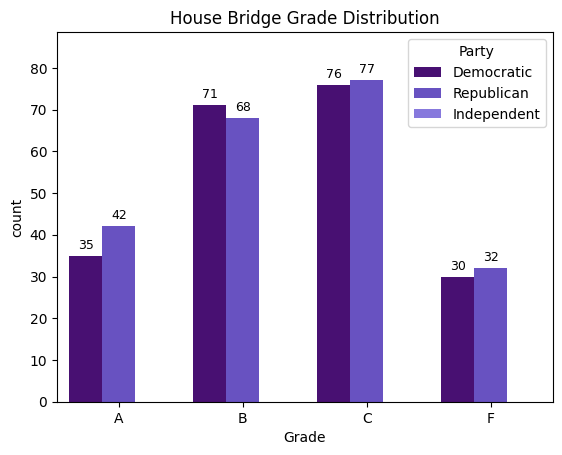

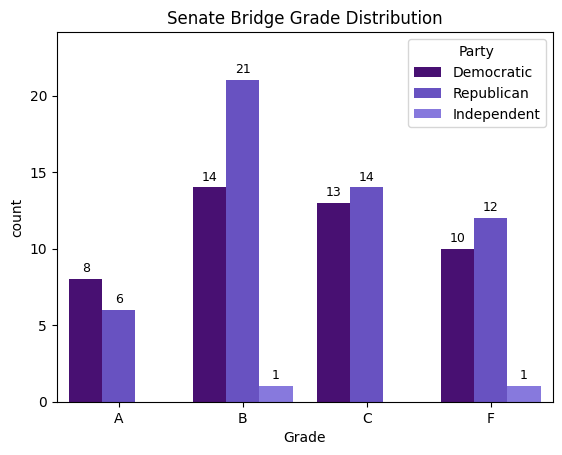

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ["A", "B", "C", "F"]
hue_order = ['Democratic', 'Republican', 'Independent']

purple_palette = ["#4B0082", "#5D3FD3", "#7B68EE"]

def plot_with_counts(data, title):
    ax = sns.countplot(
        x='Grade',
        hue='Party',
        data=data,
        palette=purple_palette,
        order=order,
        hue_order=hue_order
    )
    ax.set_title(title)

    # Calcular el valor máximo para ajustar el límite superior
    max_height = max([p.get_height() for p in ax.patches])
    ax.set_ylim(0, max_height * 1.15)  # 15% extra arriba

    # Etiquetas
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(
                f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points'
            )

    plt.show()

# House
plot_with_counts(house_final_test, "House Bridge Grade Distribution")

# Senate
plot_with_counts(senate_final_test, "Senate Bridge Grade Distribution")

#### **Clean up for final output**

##### **Party**

In [ ]:
# meta_data["Party"] is R, if the party is Republican, D if Democrat, I if Independent
house_final_test["Party_Abbr"] = house_final_test["Party"].replace({
    "Republican": "R",
    "Democratic": "D",
    "Independent": "I"
})

In [ ]:
# meta_data["Party"] is R, if the party is Republican, D if Democrat, I if Independent
senate_final_test["Party_Abbr"] = senate_final_test["Party"].replace({
    "Republican": "R",
    "Democratic": "D",
    "Independent": "I"
})

##### **district and state_district**

In [ ]:
# State name → USPS abbreviations

state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia':'DC'

}

house_final_test['State_Abbr'] = house_final_test['State'].str.strip().map(state_abbr)
senate_final_test['State_Abbr'] = senate_final_test['State'].str.strip().map(state_abbr)

In [ ]:
# Build "State_District" key with zero-padded two digits
def make_sd(df, state_col, dist_col):

    # Convert district strings to numeric, default 1 for non‐numeric (at‐large)
    dist_num = pd.to_numeric(df[dist_col], errors='coerce').fillna(1).replace(0, 1).astype(int)

    # Zero‐pad to two digits
    dist_str = dist_num.apply(lambda d: f"{d:02d}")
    return df[state_col].astype(str) + '-' + dist_str

house_final_test['District_Abbr'] = make_sd(house_final_test,  'State_Abbr', 'District')
senate_final_test['District_Abbr'] = senate_final_test['State_Abbr']

In [ ]:
# List of at-large state abbreviations
at_large_states = ['AK', 'DE', 'ND', 'SD', 'VT', 'WY']

# Update District_Abbr only for at-large states
house_final_test.loc[house_final_test['State_Abbr'].isin(at_large_states), 'District_Abbr'] = \
    house_final_test['State_Abbr'] + '-AL'

##### **Reorganize columns**

In [ ]:
house_final_test=house_final_test[['bioguide_id', 'Name', 'first_name', 'middle_name', 'last_name',
       'nickname', 'Chamber', 'State','State_Abbr', 'District','District_Abbr', 'Party', 'Party_Abbr', 'start_year',
       'end_year', 'update_date', 'image_url',
       'A: num_bills_with_cross_party_cosponsors', 'norm_A',
       'B: num_cross_party_cosponsored_bills', 'norm_B',
       'C: outcome_bipartisanship', 'norm_C', 'D: outcome_bipartisanship_pct',
       'norm_D', 'E: attack_personal', 'norm_E', 'F: attack_personal_pct',
       'norm_F', 'Cook PVI Raw', 'nominate_dim1', 'ideology_dist', 'P_flag',
       'score_T', 'bonus_m', 'bonus_n', 'bonus_p', 'score_U', 'norm_U',
       'Grade']]

In [ ]:
senate_final_test=senate_final_test[['bioguide_id', 'Name', 'first_name', 'middle_name', 'last_name',
       'nickname', 'Chamber', 'State','State_Abbr', 'District','District_Abbr', 'Party', 'Party_Abbr', 'start_year',
       'end_year', 'update_date', 'image_url',
       'A: num_bills_with_cross_party_cosponsors', 'norm_A',
       'B: num_cross_party_cosponsored_bills', 'norm_B',
       'C: outcome_bipartisanship', 'norm_C', 'D: outcome_bipartisanship_pct',
       'norm_D', 'E: attack_personal', 'norm_E', 'F: attack_personal_pct',
       'norm_F', 'Cook PVI Raw', 'nominate_dim1', 'ideology_dist', 'P_flag',
       'score_T', 'bonus_m', 'bonus_n', 'bonus_p', 'score_U', 'norm_U',
       'Grade']]

In [ ]:
# Export to Excel
house_final_test.to_excel(f'house_scores_119_{datetime.now().strftime("%Y-%m-%d")}.xlsx',  sheet_name='119 Grades', index=False)
senate_final_test.to_excel(f'senate_scores_119_{datetime.now().strftime("%Y-%m-%d")}.xlsx', sheet_name='119 Grades', index=False)